# Dummy Data Example

Suppose we have 1000 data and we dont know any thing about data. Now we want to generate more samples using those 1000 samples which follows the same distribution as provious samples.


In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd

In [2]:
MEAN = 10
SCALE = 3
SAMPLE_SIZE = 100_000

# population of 30_000 with mean 10 and scale = 3
population = np.random.normal(MEAN, SCALE, SAMPLE_SIZE)
population

array([ 9.65851487,  6.72435283, 10.16533871, ...,  2.67024989,
        8.39846488, 12.88918326])

10.01259084191325

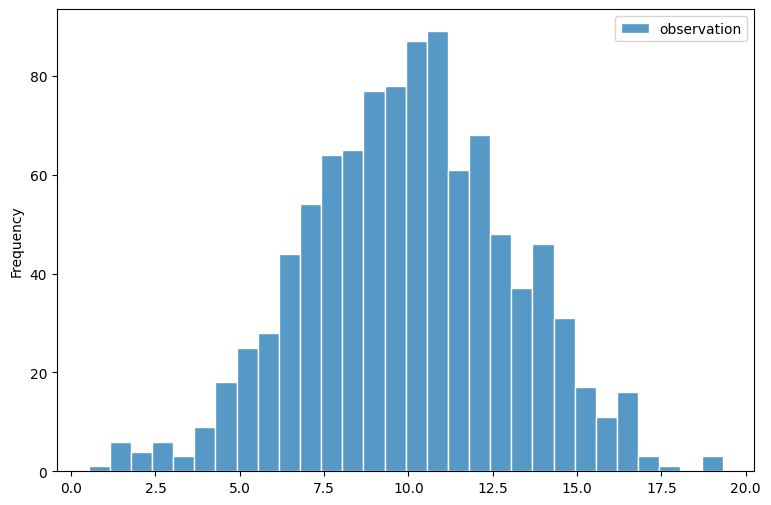

In [3]:
# we are only abel to observe 1000 sample
observation = population[np.random.randint(0, SAMPLE_SIZE, 1000)]

plt.figure(figsize=(9, 6))
sns.histplot(observation, edgecolor="w", bins=30, label="observation")
plt.legend()
plt.ylabel("Frequency")

mu_obs = np.mean(observation)
mu_obs

## Now we want to generate more sample using those 1000 observation

We know the mean of 1000 sample. But we don't know the variance.
So we have to find the variance to 1000 sample by M-H algorithm using bayesian statics.

$$ P\left( \theta| D \right) = \dfrac{P\left( {D}|{\theta} \right) P(\theta)}{P(D)}. $$

where,

- $P(\theta|D)$ is the posterior. What we wish to compute.
- $P(D|\theta)$ is the **likelihood**. Assuming $D$ occurred, how likely is $\theta$.
- $P(\theta)$ is the **prior**. How likely the event $\theta$ is regardless of evidence.
- $P(D)$ is the _evidence_.

Here, its looks like 1000 sample follows Normal Distribution whose mean is $\mu_{obs}$. We have to find variance of the desiar normal distribution. i.e. $P(\theta|D)$ where, $\theta := (\mu_{obs}, \sigma)$.

### PDF of $P(D|\theta)$:

$$
    P(d_i|\theta) = f(d_i|\mu, \sigma) = \dfrac{1}{\sqrt{2\pi \sigma^2}}e^{-\dfrac{(d_i-\mu)^2}{2\sigma^2}} .
$$

where, $\mu = \mu_{obs}$.

### Transition probability:

we choose $Q$ to be,

$$
    Q(\sigma_{new}|\sigma_{current}) = N(\sigma_{current}, 1)
$$

### Define when we accept or reject $\sigma_{new}$:

We accept $\sigma_{new}$ if:

$\dfrac{Likelihood(D/\mu_{obs},\sigma_{new})*prior(\mu_{obs},\sigma_{new})}{Likelihood(D/\mu_{obs},\sigma_{current})*prior(\mu_{obs},\sigma_{current})}>1     \quad \quad \quad \quad \quad      (1)$

If this ratio is smaller or equal to 1, then we compare it to a uniformly generated random number in the closed set [0,1]. If the ratio is larger than the random number, we accept $\sigma_{new}$, otherwise we reject it.

_Note: Since we will be computing this ratio to decide which parameters should be accepted, it is imperative to make sure that the adopted function $f$ is proportional to the posterior itself, $P(\sigma/ D,\mu)$, which in that case is verified. ($f$ is the PDF of P)_

### For the Prior $P(\theta)$ which we can alternatively note $P(\sigma)$ since $\mu$ is constant:

We don't have any preferences for the values that $\sigma_{new}$ and $\sigma_{current}$ can take. The only thing worth noting is that they should be positive. Why? Intuitively, the standard deviation measures dispersion. Dispersion is a distance, and distances cannot be negative. Mathematically, $\sigma=\sqrt{\dfrac{1}{n}\sum_i^n(d_i-\mu)^2}$, and the square root of a number cannot be negative. We strictly enforce this in the prior.

Hence we choose the pdf of $P(\sigma)$ to be:

$$
    P(\sigma) = \begin{cases}
        0,\ \  \sigma \le 0\\
        1,\ \ \sigma > 0
    \end{cases}
$$

### For Likelihood function:

The total likelihood for a set of observation $D$ is: $Likelihood(D|\mu_{obs},\sigma_{a}) = \prod_i^n f(d_i|\mu_{obs},\sigma_{a}) $, where $a=new \: or \: current$.

In our case, we will log both the prior and the likelihood function. Why log? Simply because it helps with numerical stability, i.e. multiplying thousands of small values (probabilities, likelihoods, etc..) can cause an underflow in the system's memory, and the log is a perfect solution because it transforms multiplications to additions and small positive numbers into non-small negative numbers.

Now we accept $\sigma_{new}$ if: (from (1))

$$
    \log(Likelihood(D|\mu_{obs},\sigma_{new})) + \log(prior(\mu_{obs},\sigma_{new})) - (\log(Likelihood(D|\mu_{obs},\sigma_{current}))- \log(prior(\mu_{obs},\sigma_{current})))>0
$$

$$
    \sum_i^n\log(f(d_i|\mu_{obs},\sigma_{new})) + \log(prior(\mu_{obs},\sigma_{new})) > \sum_i^n\log(f(d_i|\mu_{obs},\sigma_{current}))+\log(prior(\mu_{obs},\sigma_{current}))
$$

$$
    \sum_i^n \left( - \log( \sigma_{new} \sqrt{2 \pi} ) - \frac{(d_i-\mu)^2}{2\sigma_{new}^2} \right) + \log(prior(\mu_{obs}, \sigma_{new})) > \sum_i^n \left( - \log( \sigma_{current} \sqrt{2 \pi} ) - \frac{(d_i-\mu)^2}{2\sigma_{current}^2} \right) + \log(prior(\mu_{obs}, \sigma_{current}))
$$


In [4]:
def prior(current_state):
    if current_state <= 0:
        return 0
    else:
        return 1


def log_like_normal(mu, sigma, data):
    return np.sum(
        -np.log(sigma * np.sqrt(2 * np.pi)) - ((data - mu) ** 2) / (2 * sigma**2)
    )


def acceptance(current, new):
    if new > current:
        return True
    else:
        accept = np.random.uniform(0, 1)
        # since we are dealing with log of likelihood function so we have to take exp.
        return accept < (np.exp(new - current))


def Metropolis(
    prior, log_like_normal, acceptance, mu, init_state, data, sample_size=SAMPLE_SIZE
):
    current_state = init_state
    samples = []
    for _ in range(sample_size):
        candidate_state = np.random.normal(loc=current_state, scale=1, size=1)
        current_likelihood = log_like_normal(mu, current_state, data)
        candidate_likelihood = log_like_normal(mu, candidate_state, data)
        if acceptance(
            current_likelihood + np.log(prior(current_state)),
            candidate_likelihood + np.log(prior(candidate_state)),
        ):
            current_state = candidate_state
            samples.append(current_state)
    return np.array(samples)

In [5]:
# running mean
def RunningMeans(sample):
    cumulative_sum = np.cumsum(sample)
    indices = np.arange(1, len(cumulative_sum) + 1)
    running_means = cumulative_sum / indices
    return running_means

In [6]:
np.random.seed(1)

samples_of_sigma = Metropolis(
    prior, log_like_normal, acceptance, mu_obs, 0.1, population
)

/tmp/ipykernel_101791/1006772885.py:10: RuntimeWarning: invalid value encountered in log
  -np.log(sigma * np.sqrt(2 * np.pi)) - ((data - mu) ** 2) / (2 * sigma**2)
/tmp/ipykernel_101791/1006772885.py:34: RuntimeWarning: divide by zero encountered in log
  candidate_likelihood + np.log(prior(candidate_state)),


#### Last 10 samples and shape od samples

Here only around 1670 number of sample get accepcted (can be changeg).


In [7]:
print(samples_of_sigma.shape)
print(samples_of_sigma[-10:])

(862, 1)
[[3.00535397]
 [2.99573497]
 [2.9920793 ]
 [2.99104245]
 [3.00084842]
 [3.00006672]
 [2.99668656]
 [3.00414961]
 [3.0045794 ]
 [2.98600462]]


In [8]:
samples_of_sigma[-10:, 0]

array([3.00535397, 2.99573497, 2.9920793 , 2.99104245, 3.00084842,
       3.00006672, 2.99668656, 3.00414961, 3.0045794 , 2.98600462])

In [9]:
running_mean_ib = RunningMeans(samples_of_sigma[:, 0])

Text(0.5, 0, 'Number of iteration')

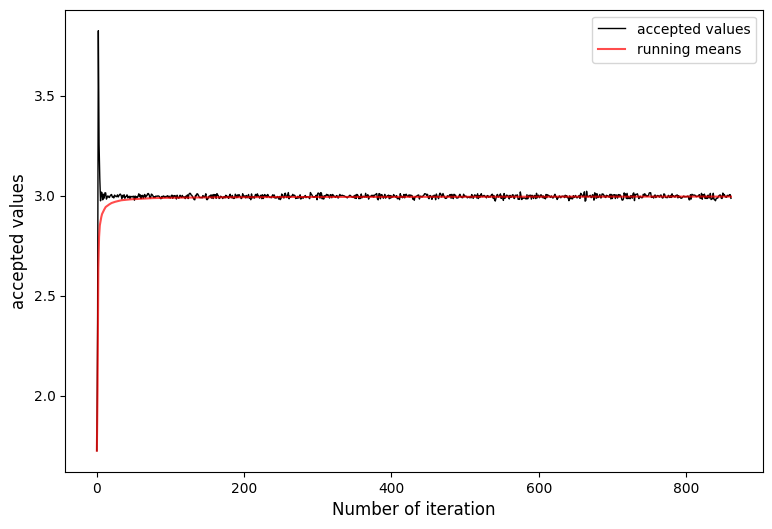

In [18]:
plt.figure(figsize=(9, 6))
sns.lineplot(
    x=range(len(samples_of_sigma)),
    y=samples_of_sigma[:, 0],
    color="k",
    linewidth=1,
    label="accepted values",
)
sns.lineplot(
    x=range(len(running_mean_ib)),
    y=running_mean_ib,
    color="r",
    alpha=0.7,
    label="running means",
)
plt.ylabel("accepted values", fontsize=12)
plt.xlabel("Number of iteration", fontsize=12)

### We consider the inetial 25% of values to "burn-in", so we drop them.


In [11]:
burn_in = int(0.25 * len(samples_of_sigma))
running_means = RunningMeans(samples_of_sigma[burn_in:, 0])

In [12]:
# for geweke z score
df = pd.DataFrame(samples_of_sigma[burn_in:, 0])
df.to_csv("sample-of-sigma.csv")

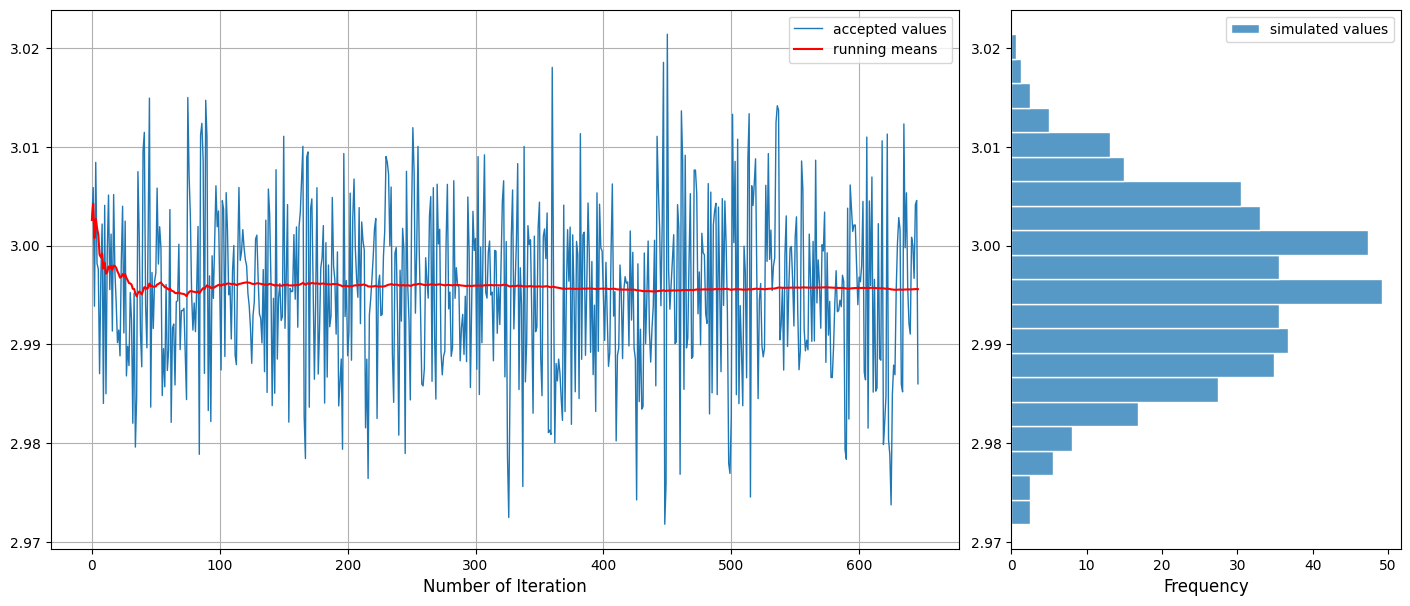

In [13]:
# Create subplots with specified width ratios
fig, axs = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={"width_ratios": [7, 3]})
plt.subplots_adjust(right=0.8, wspace=0.08)

# First subplot: line plot
axs[0].grid()
sns.lineplot(
    ax=axs[0],
    x=range(len(samples_of_sigma[burn_in:, 0])),
    # color="k",
    linewidth=1,
    y=samples_of_sigma[burn_in:, 0],
    label="accepted values",
)
sns.lineplot(
    ax=axs[0],
    x=range(len(running_means)),
    y=running_means,
    color="red",
    label="running means",
)
axs[0].set_xlabel("Number of Iteration", fontsize=12)
# axs[0].set_ylabel("Accepted Value", fontsize=12)

# Second subplot: histogram plot
sns.histplot(
    ax=axs[1],
    y=samples_of_sigma[burn_in:, 0],
    stat="density",
    # color="black",
    edgecolor="white",
    # kde=True,
    linewidth=1,
    bins=20,
    label="simulated values",
)
axs[1].set_xlabel("Frequency", fontsize=12)

plt.legend()
# Show the plot
plt.show()

In [14]:
sigam_obs = samples_of_sigma[burn_in:].mean()
print(f"Mean of sigmas: {sigam_obs:.4f}")
print(f"Mean of sigmas: {samples_of_sigma[burn_in:].var():.4f}")

Mean of sigmas: 2.9956
Mean of sigmas: 0.0001


Now we get the variance of sample is $\sigma_{obs}$.

Now, we can generate the the random samples from $N(\mu_{obs}, \sigma_{obs})$ and it will be pretty closed to the original population.

## Predction:


experimental Mean: 10.01259084191325, Variance: 2.9955916072689597


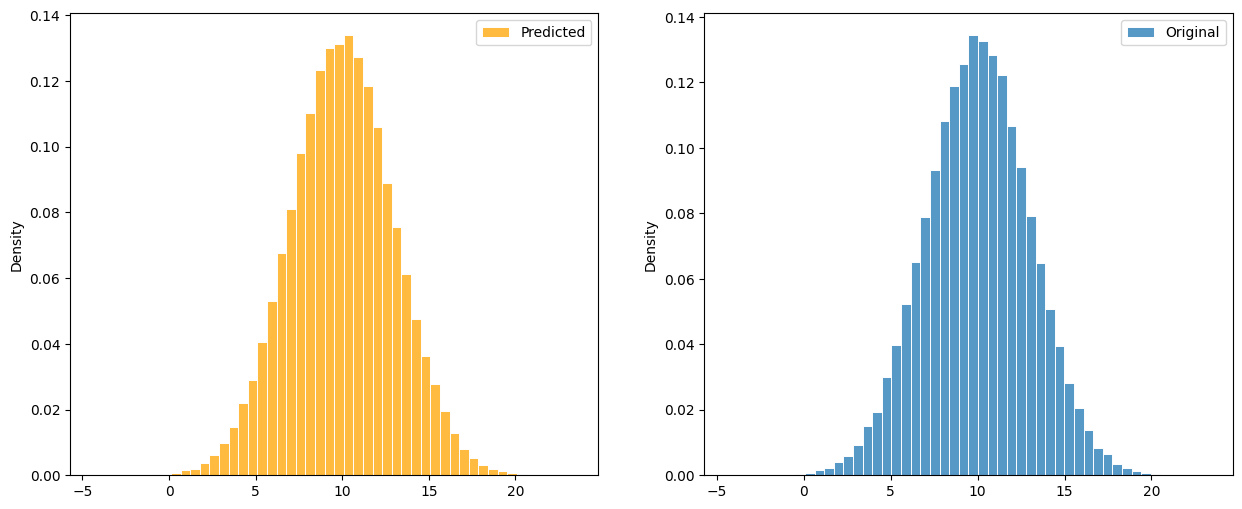

In [15]:
np.random.seed(3)

print(f"experimental Mean: {mu_obs}, Variance: {sigam_obs}")
experemental_population = np.random.normal(10, sigam_obs, SAMPLE_SIZE)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(
    experemental_population,
    color="orange",
    edgecolor="w",
    bins=50,
    stat="density",
    label="Predicted",
)
plt.legend()
plt.subplot(1, 2, 2)
sns.histplot(population, bins=50, edgecolor="w", stat="density", label="Original")
plt.legend()

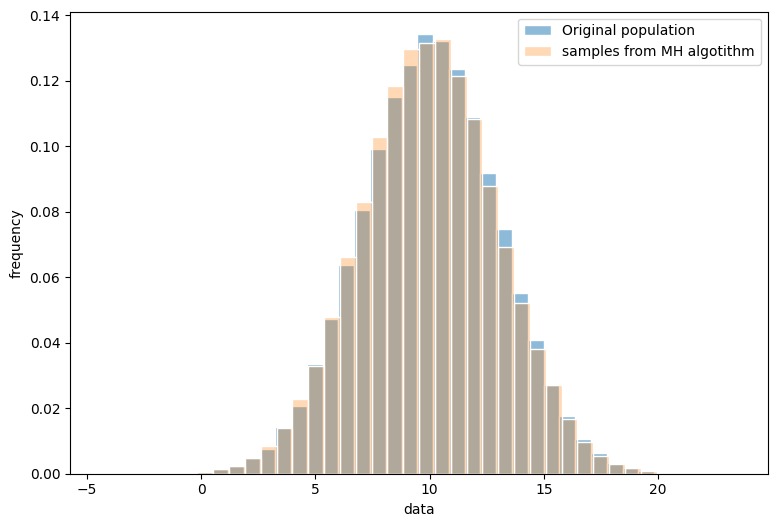

In [16]:
plt.figure(figsize=(9, 6))
sns.histplot(
    population,
    bins=40,
    edgecolor="w",
    stat="density",
    label="Original population",
    alpha=0.5,
)
sns.histplot(
    experemental_population,
    bins=40,
    edgecolor="w",
    stat="density",
    label="samples from MH algotithm",
    alpha=0.3,
)
plt.xlabel("data")
plt.ylabel("frequency")
plt.legend()

## may be deleted


In [17]:
t_stat, p_value = stats.ttest_ind(experemental_population, population)
print(f"{t_stat}, {p_value}")

0.2079197558687044, 0.8352918350124352


## Z-test

$$
    \text{z-score} = \frac{(\bar{X_1} - \bar{X_2}) - (\mu_1 - \mu_2)}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2} }}
$$

Where, $\bar{X_i}$ are sample mean, $\mu_i$ are mean of the sample, $\sigma_i$ are sample standrad deviation.

The $H_0$:null hypothesis is $(\mu_1 - \mu_2) = 0$.


In [18]:
print(experemental_population.mean(), experemental_population.std())
print(population.mean(), population.std())

X1_bar = experemental_population.mean()
X2_bar = population.mean()
sigma1 = experemental_population.std()
sigma2 = population.std()

alpha = 0.05

z_score = (X1_bar - X2_bar) / (np.sqrt(sigma1**2 + sigma2**2))
print(z_score)

p_value = 2 * stats.norm.cdf(np.abs(z_score))
print(p_value)

9.993081453758396 2.993266853492353
9.990294474697585 3.001197686213456
0.0006575032866159193
1.000524611683269
